# Data Preprocessing

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Reading Data**

In [234]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Interview_Assignments/autoScout24/case_study_data.csv', delimiter=';')
data_desc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Interview_Assignments/autoScout24/data_description.csv', delimiter=';')

In [235]:
data.head()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403
1,354412280,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008
2,349572992,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013
3,350266763,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173
4,355688985,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224


In [236]:
data.shape

(78321, 12)

#Feature Engineering and Analysis

Count plot of Product Tier Categories

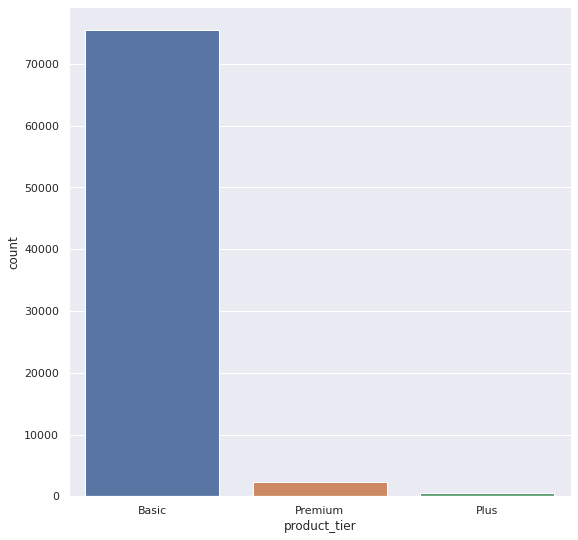

In [237]:
plt.figure(figsize=(9,9))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="product_tier", data=data)

#Handling Missing Values

In [238]:
data.isna().sum()

article_id                  0
product_tier                0
make_name                   0
price                       0
first_zip_digit             0
first_registration_year     0
created_date                0
deleted_date                0
search_views               10
detail_views               10
stock_days                  0
ctr                        24
dtype: int64

In [239]:
rows_with_na_values = data[data.isnull().any(axis=1)].product_tier.unique()
rows_with_na_values

array(['Basic'], dtype=object)

**Very few records have NA values and Also, all rows with NA values have "Basic" Product tier category (which is in very high majority in our dataset); so we are goint to drop rows with missing values.**

In [240]:
data = data.dropna()
data.shape

(78297, 12)

In [241]:
from sklearn.preprocessing import OneHotEncoder

In [242]:
data.head()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403
1,354412280,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008
2,349572992,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013
3,350266763,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173
4,355688985,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224


**Ordinal Label Encoding of Product Tier Feature**

Basic - 0, Premium - 1, Plus - 2

In [243]:
print(data.product_tier.unique())
data["product_tier"] = data["product_tier"].replace("Basic", 0).replace("Premium", 1).replace("Plus", 2)
print(data.product_tier.unique())

['Basic' 'Premium' 'Plus']
[0 1 2]


**one hot encoding of "first_zip_digit" feature**

And dropping "first_zip_digit" feature

Text(0, 0.5, 'Detail Views')

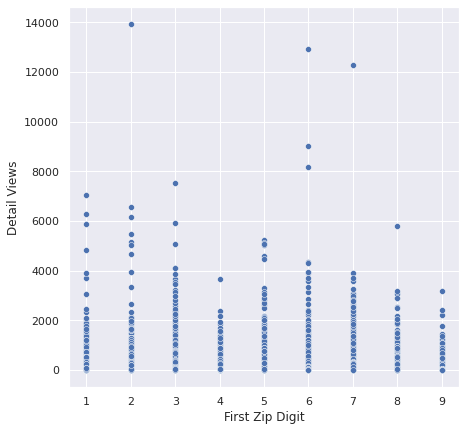

In [244]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=data, x="first_zip_digit", y="detail_views")
# Set x-axis label
plt.xlabel('First Zip Digit')
# Set y-axis label
plt.ylabel('Detail Views')

In [245]:
zip_code_dummies = pd.get_dummies(data.first_zip_digit,drop_first=True, prefix='zip_code')
data = pd.concat([data, zip_code_dummies], axis=1)

In [246]:
data = data.drop('first_zip_digit', 1)

**One hot encoding of "make_name" feature**

"make_name" has 91 categories, we are going to one hot encode and choose top 10 categories only

In [247]:
data.make_name.value_counts().sort_values(ascending=False).head(10)

Volkswagen       9424
Renault          6954
Peugeot          5446
Opel             5217
Ford             5198
Mercedes-Benz    4758
BMW              4553
Volvo            3993
Toyota           3924
Audi             3311
Name: make_name, dtype: int64

In [248]:
lst_10=data.make_name.value_counts().sort_values(ascending=False).head(10).index
lst_10=list(lst_10)

In [249]:
for category in lst_10:
    data[category]=np.where(data['make_name']==category,1,0)

In [250]:
data.head()

,article_id,product_tier,make_name,price,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,zip_code_2,zip_code_3,zip_code_4,zip_code_5,zip_code_6,zip_code_7,zip_code_8,zip_code_9,Volkswagen,Renault,Peugeot,Opel,Ford,Mercedes-Benz,BMW,Volvo,Toyota,Audi
0,350625839,0,Mitsubishi,16750,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,354412280,0,Mercedes-Benz,35950,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,349572992,0,Mercedes-Benz,11950,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,350266763,0,Ford,1750,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,355688985,0,Mercedes-Benz,26500,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [251]:
# Dropping make_name column
data = data.drop('make_name', 1)

In [252]:
# Dropping Article_id 
data = data.drop('article_id', 1)

#Handling Date Variables

Converting date value columns to "DATE" type and extracting only year

In [253]:
data['created_date'] = data['created_date'].str.replace('.','/')

data["created_date"] = pd.to_datetime(data["created_date"], dayfirst=True).dt.year

In [254]:
# Dropping deleted_date as stock_days covers the value between created_date and deleted_date
data = data.drop('deleted_date', 1)

**Checking for invalid values in "registration year" column**

the invalid value are the one where registration years is after "created_year"

In [255]:
temp_df = data[data.first_registration_year > data.created_date]
temp_df.shape

(74, 26)

In [256]:
# dropping row with invalid "registration_year" value (where registration year > creation date)
# data.drop(data.index[data['first_registration_year'] > data['created_date']], inplace = True)

In [257]:
# Creating new column (article_age), based on difference between create_date and first_registration_year
data["article_age"] = data["created_date"] - data["first_registration_year"]

In [258]:
data["article_age"].min()

-88

**Replace all "article_age" values which are less than 0 with mean "article_age"**

In [259]:
data.article_age=data.article_age.where(data.article_age.between(0,data["article_age"].max()))
data['article_age'].fillna((data['article_age'].mean()), inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


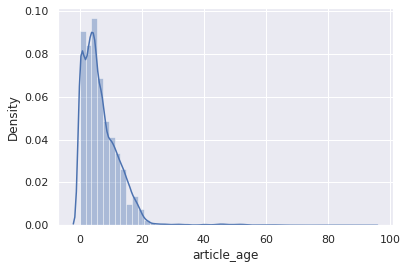

In [260]:
sns.distplot(data.article_age)

**Capping of outliers in article _age**

In [261]:
print("Max Age ", max(data.article_age))

Max Age  94.0


In [262]:
age_IQR=data.article_age.quantile(0.75)-data.article_age.quantile(0.25)

age_upper_bridge=data['article_age'].quantile(0.75)+(age_IQR*2)
print(age_upper_bridge)

24.0


In [263]:
# Capping values to 24
data.loc[data['article_age'] > 24, 'article_age'] = 24

In [264]:
# Dropping first_registration_year column
data = data.drop('first_registration_year', 1)

In [265]:
data.created_date.unique()

array([2018])

In [266]:
# there is only one value for created_date year, so we are dropping "created_date" column
data = data.drop('created_date', 1)

In [267]:
data.head()

,product_tier,price,search_views,detail_views,stock_days,ctr,zip_code_2,zip_code_3,zip_code_4,zip_code_5,zip_code_6,zip_code_7,zip_code_8,zip_code_9,Volkswagen,Renault,Peugeot,Opel,Ford,Mercedes-Benz,BMW,Volvo,Toyota,Audi,article_age
0,0,16750,3091.0,123.0,30,0.03780329990294403,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0
1,0,35950,3283.0,223.0,52,0.06792567773378008,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.0
2,0,11950,3247.0,265.0,51,0.0816137973514013,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,20.0
3,0,1750,1856.0,26.0,101,0.014008620689655173,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,15.0
4,0,26500,490.0,20.0,12,0.04081632653061224,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.0


**Convert "ctr" to float**

Ctr has invalid values, we replace all non-number values with 0 

In [268]:
data["ctr"] = pd.to_numeric(data.ctr.astype(str).str.replace(',',''), errors='coerce').astype(float)

checking for outliers in **ctr** column

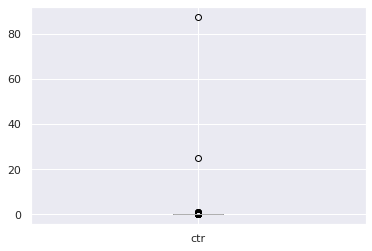

In [269]:
data.boxplot(column="ctr")

In [270]:
#### Lets compute the Interquantile range to calculate the boundaries
IQR=data.ctr.quantile(0.75)-data.ctr.quantile(0.25)

upper_bridge=data['ctr'].quantile(0.75)+(IQR*3)
print(upper_bridge)

0.16052162410858062


In [271]:
data.ctr.max()

87.5

In [272]:
# Set ctr = 0.17 for all records with ctr > .17
data.loc[data['ctr'] > .17, 'ctr'] = .17

In [273]:
#Replace missing values in ctr with the mean
data['ctr'].fillna((data['ctr'].mean()), inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


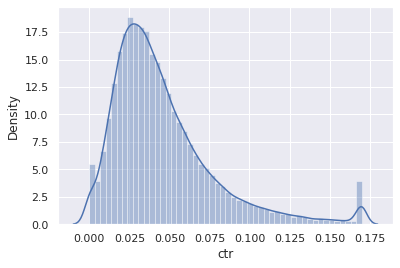

In [274]:
sns.distplot(data.ctr)

In [275]:
data.head()

,product_tier,price,search_views,detail_views,stock_days,ctr,zip_code_2,zip_code_3,zip_code_4,zip_code_5,zip_code_6,zip_code_7,zip_code_8,zip_code_9,Volkswagen,Renault,Peugeot,Opel,Ford,Mercedes-Benz,BMW,Volvo,Toyota,Audi,article_age
0,0,16750,3091.0,123.0,30,0.037803,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0
1,0,35950,3283.0,223.0,52,0.067926,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.0
2,0,11950,3247.0,265.0,51,0.081614,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,20.0
3,0,1750,1856.0,26.0,101,0.014009,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,15.0
4,0,26500,490.0,20.0,12,0.040816,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.0


**Normalize the values of price columns**

In [276]:
data['price'] = data['price'] /data['price'].abs().max() 

#Exporting processed data to new CSV file

In [277]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Interview_Assignments/autoScout24/processed_data.csv', index=False)

# Analysis

Text(0, 0.5, 'Detail Views')

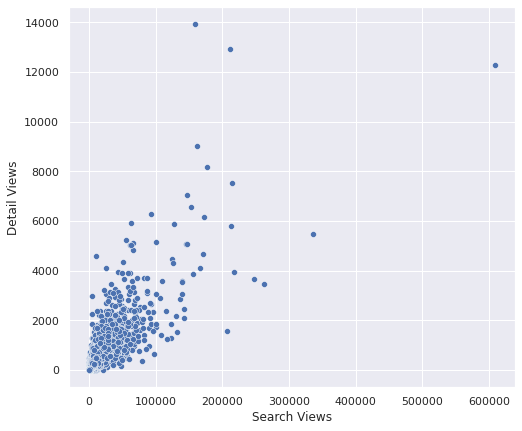

In [278]:
plt.figure(figsize=(8, 7))
sns.scatterplot(data=data, x="search_views", y="detail_views")
# Set x-axis label
plt.xlabel('Search Views')
# Set y-axis label
plt.ylabel('Detail Views')

Text(0, 0.5, 'Detail Views')

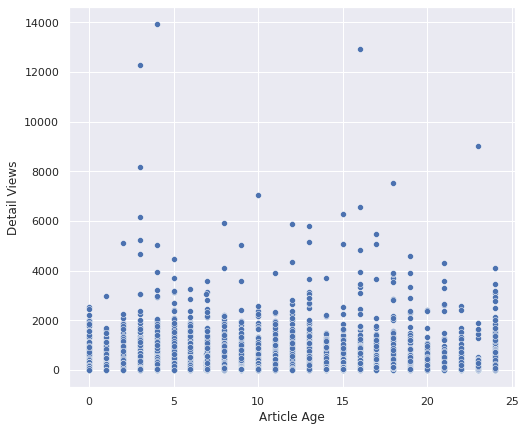

In [279]:
plt.figure(figsize=(8, 7))
sns.scatterplot(data=data, x="article_age", y="detail_views")
# Set x-axis label
plt.xlabel('Article Age')
# Set y-axis label
plt.ylabel('Detail Views')

Text(0, 0.5, 'Detail Views')

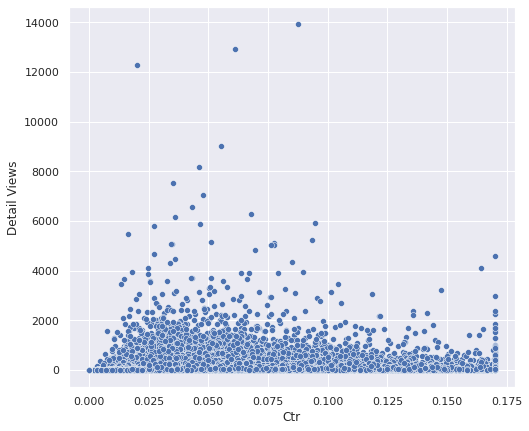

In [280]:
plt.figure(figsize=(8, 7))
sns.scatterplot(data=data, x="ctr", y="detail_views")
# Set x-axis label
plt.xlabel('Ctr')
# Set y-axis label
plt.ylabel('Detail Views')